We Import needed libraries and methods.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom, gaussian_kde

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


We load the files with p values calculated for data without dependencies and with no differences between the groups.

In [3]:
independent_p_values_pool_list = []

for file in os.listdir('data/independent_p_values/'):
    independent_p_values_from_file = np.loadtxt(f'data/independent_p_values/{file}', delimiter='\t')
    independent_p_values_pool_list.append(independent_p_values_from_file)

independent_p_values_pool = np.column_stack(independent_p_values_pool_list) 

We find significant p values for each dataset.

In [4]:
alpha = 0.05
independent_p_values_pool_binary = independent_p_values_pool < alpha
number_of_trues_independent_p_values_pool_binary = np.sum(independent_p_values_pool_binary, axis=0)

We plot the histogram of number of significant findings in independent p values pool along with binomial distribution.

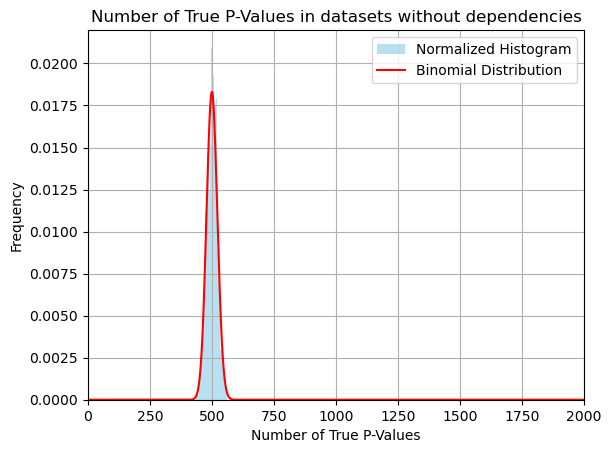

In [5]:
n = independent_p_values_pool_binary.shape[0]
p = np.mean(number_of_trues_independent_p_values_pool_binary) / n

plt.hist(number_of_trues_independent_p_values_pool_binary, color='skyblue', bins=30, alpha=0.6, label='Normalized Histogram', density=True)

x = np.arange(0, n+1)
pmf = binom.pmf(x, n, p)
plt.plot(x, pmf, color='red', label='Binomial Distribution')
plt.xlabel('Number of True P-Values')
plt.ylabel('Frequency')
plt.title('Number of True P-Values in datasets without dependencies')
plt.legend()
plt.grid(True)

plt.xlim(0, 2000)  #zoom in

plt.show()

We can see that the histogram of number of significant findings in independent p values pool resembles binomial distribution for n=10000 and p=0.05 (alpha).

Now we look at the p values for data with dependencies. First, we start analysis on a single dataset.

We load the file with synthetic methylation data (without signal) that was found to have increased number of significant findings and the p values computed for it with 2 group t-test. 

In [6]:
dataset_with_dependencies = np.loadtxt('data/raw/id~3564.tsv', delimiter='\t')
p_values_of_dataset_with_dependencies = np.loadtxt('data/p_values/id~3564.tsv', delimiter='\t')

We also binarize p values to find significant findings.

In [7]:
alpha = 0.05
p_values_of_dataset_with_dependencies_binary = p_values_of_dataset_with_dependencies < alpha

We visualise correlations in p values of at proximal sites by plotting a scatter plot of each p value against the next one.

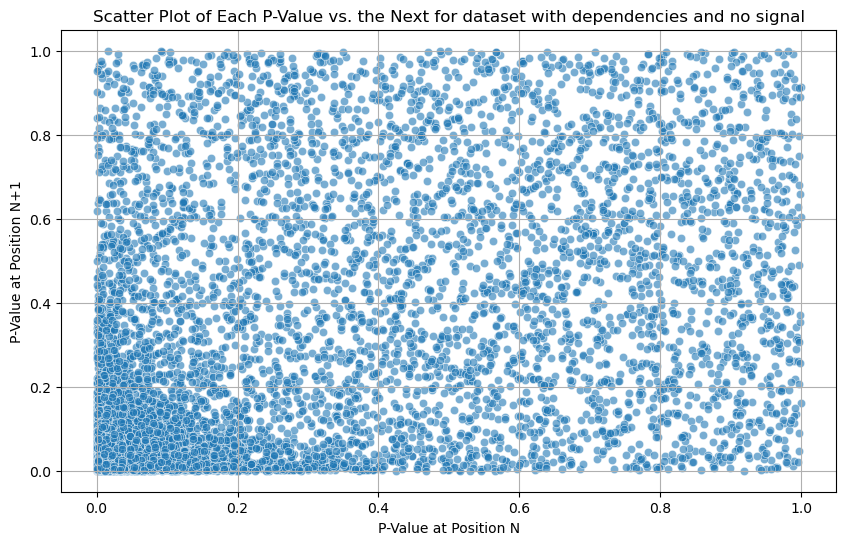

In [8]:
n_p_values_of_dataset_with_dependencies = p_values_of_dataset_with_dependencies[:-1]  # All except the last p-value
n_minus_p_values_of_dataset_with_dependencies = p_values_of_dataset_with_dependencies[1:]   # All except the first p-value

plt.figure(figsize=(10, 6))
plt.scatter(n_p_values_of_dataset_with_dependencies, n_minus_p_values_of_dataset_with_dependencies, alpha=0.6, edgecolors='w', linewidths=0.5)
plt.title('Scatter Plot of Each P-Value vs. the Next for dataset with dependencies and no signal')
plt.xlabel('P-Value at Position N')
plt.ylabel('P-Value at Position N+1')
plt.grid(True)
plt.show()

We see that the p values are correlated at proximal sites when the p values are low. For higher p values, the correlation is not very clear.

We calculate the Pearson correlation coefficient for the p-values at proximal sites.

In [9]:
correlation_p_values_of_dataset_with_dependencies = np.corrcoef(n_p_values_of_dataset_with_dependencies, n_minus_p_values_of_dataset_with_dependencies)[0, 1]
correlation_p_values_of_dataset_with_dependencies

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.5110654103922284

The Pearson correlation of p values at proximal sites in a datset with dependencies and no signal is 0.51, which is quite high.

We create a function to calculate the 2x2 table with the probabilities of the current p value being below alpha given the previous p value is below or above alpha.

In [10]:
def calculate_pvalue_table(p_values, alpha):
    count_below_below = 0
    count_below_above = 0
    count_above_below = 0
    count_above_above = 0

    # Iterate over the p-values, skipping the last one to compare pairs
    for i in range(len(p_values) - 1):
        current_below_alpha = p_values[i] < alpha
        next_below_alpha = p_values[i+1] < alpha

        if current_below_alpha:
            if next_below_alpha:
                count_below_below += 1
            else:
                count_below_above += 1
        else:
            if next_below_alpha:
                count_above_below += 1
            else:
                count_above_above += 1

    total_below = count_below_below + count_below_above
    total_above = count_above_below + count_above_above

    table = np.array([
        [count_below_below / total_below if total_below else 0, count_below_above / total_below if total_below else 0],
        [count_above_below / total_above if total_above else 0, count_above_above / total_above if total_above else 0]
    ])

    return table

In [11]:
alpha = 0.05
significant_values_probability_table = calculate_pvalue_table(p_values_of_dataset_with_dependencies, alpha)
print("Probability table:")
print("                    Current p-value < alpha | Current p-value >= alpha")
print(f"Previous < alpha: {significant_values_probability_table[0, 0]:.2f}                      | {significant_values_probability_table[0, 1]:.2f}")
print(f"Previous >= alpha: {significant_values_probability_table[1, 0]:.2f}                     | {significant_values_probability_table[1, 1]:.2f}")

Probability table:
                    Current p-value < alpha | Current p-value >= alpha
Previous < alpha: 0.60                      | 0.40
Previous >= alpha: 0.26                     | 0.74


We see that the chance of the current p value being below alpha is higher if the previous p value is below alpha for a dataset with correlations.

We calculate the Pearson correlation coefficient for the binary p values at proximal sites.

In [12]:
n_p_values_of_dataset_with_dependencies_binary = p_values_of_dataset_with_dependencies_binary[:-1]  # All except the last p-value
n_minus_p_values_of_dataset_with_dependencies_binary = p_values_of_dataset_with_dependencies_binary[1:]   # All except the first p-value
correlation_p_values_of_dataset_with_dependencies_binary = np.corrcoef(n_p_values_of_dataset_with_dependencies_binary, n_minus_p_values_of_dataset_with_dependencies_binary)[0, 1]
correlation_p_values_of_dataset_with_dependencies_binary

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.34199081995356756

In binary case, the Pearson correlation is 0.34 which is lower than for non-binary case, but still quite high.

To check the correlation between the p values at random sites, we shuffle p values and plot the scatter plot again.

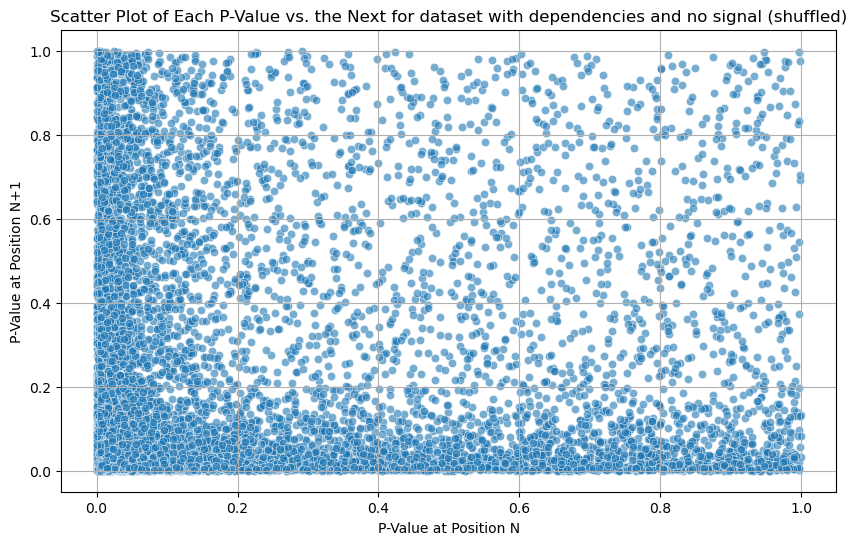

In [13]:
shuffled_p_values_of_dataset_with_dependencies = np.random.permutation(p_values_of_dataset_with_dependencies)

n_shuffled_p_values_of_dataset_with_dependencies = shuffled_p_values_of_dataset_with_dependencies[:-1]  # All except the last p-value
n_minus_shuffled_p_values_of_dataset_with_dependencies = shuffled_p_values_of_dataset_with_dependencies[1:]   # All except the first p-value

plt.figure(figsize=(10, 6))
plt.scatter(n_shuffled_p_values_of_dataset_with_dependencies, n_minus_shuffled_p_values_of_dataset_with_dependencies, alpha=0.6, edgecolors='w', linewidths=0.5)
plt.title('Scatter Plot of Each P-Value vs. the Next for dataset with dependencies and no signal (shuffled)')
plt.xlabel('P-Value at Position N')
plt.ylabel('P-Value at Position N+1')
plt.grid(True)
plt.show()

We see that the points are not uniformly distributed. The concentration of points on x and y axes might be due to the fact that in this dataset there's a lot of p values close to 0. They are however more distributed than for non-shuffled p values.

In [14]:
correlation_shuffled_p_values_of_dataset_with_dependencies = np.corrcoef(n_shuffled_p_values_of_dataset_with_dependencies, n_minus_shuffled_p_values_of_dataset_with_dependencies)[0, 1]
correlation_shuffled_p_values_of_dataset_with_dependencies

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.007383095325977219

The correlation for shuffled p values is almost 0 (-0.009), which aligns with the fact that the p values are not correlated at random sites.

In [15]:
alpha = 0.05
table = calculate_pvalue_table(shuffled_p_values_of_dataset_with_dependencies, alpha)
print("Probability table:")
print("                     Current p-value < alpha | Current p-value >= alpha")
print(f"Previous < alpha: {table[0, 0]:.2f}                       | {table[0, 1]:.2f}")
print(f"Previous >= alpha: {table[1, 0]:.2f}                      | {table[1, 1]:.2f}")

Probability table:
                     Current p-value < alpha | Current p-value >= alpha
Previous < alpha: 0.40                       | 0.60
Previous >= alpha: 0.40                      | 0.60


When we shuffled the data, the chance of the current p value being below alpha is not dependent on whether the previous p value is below alpha or not.

We also binarize shuffled p values to find significant findings and calculate the Pearson correlation coefficient.

In [16]:
shuffled_p_values_of_dataset_with_dependencies_binary = shuffled_p_values_of_dataset_with_dependencies < alpha
n_shuffled_p_values_of_dataset_with_dependencies_binary = shuffled_p_values_of_dataset_with_dependencies_binary[:-1]  # All except the last p-value
n_minus_shuffled_p_values_of_dataset_with_dependencies_binary = shuffled_p_values_of_dataset_with_dependencies_binary[1:]   # All except the first p-value
correlation_shuffled_p_values_of_dataset_with_dependencies_binary = np.corrcoef(n_shuffled_p_values_of_dataset_with_dependencies_binary, n_minus_shuffled_p_values_of_dataset_with_dependencies_binary)[0, 1]
correlation_shuffled_p_values_of_dataset_with_dependencies_binary

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


-0.0005348422829689912

We get again correlation almost 0 (-0.016), which is expected for shuffled data.

Now we will analyze p values from more datasets. We take 10000 simulated datasets with no signal, but high correlations and the calculated p values for each of them.

In [17]:
p_values_pool_list = []

for file in os.listdir('data/p_values/'):
    p_values_from_file = np.loadtxt(f'data/p_values/{file}', delimiter='\t')
    p_values_pool_list.append(p_values_from_file)

p_values_pool = np.column_stack(p_values_pool_list) 

We find significant p values for each dataset.

In [18]:
alpha = 0.05
p_values_pool_binary = p_values_pool < alpha
number_of_trues_p_values_pool_binary = np.sum(p_values_pool_binary, axis=0)

Now we plot the binomial distribution with n=10000 and p=0.05 (alpha) on top of the normalized histogram of number of rejected p-values in p-values pool.

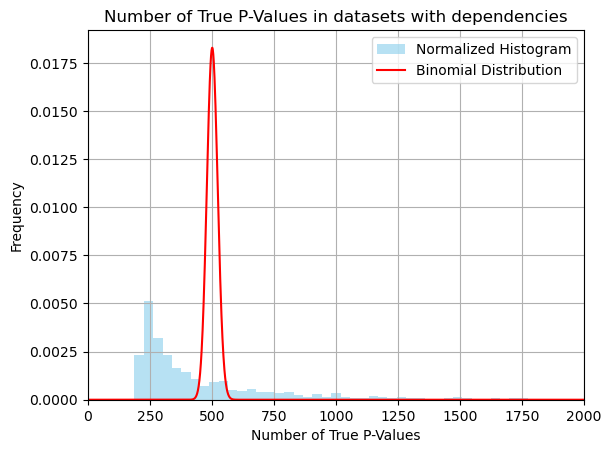

In [19]:
n = p_values_pool_binary.shape[0]
p = np.mean(number_of_trues_p_values_pool_binary) / n

plt.hist(number_of_trues_p_values_pool_binary, color='skyblue', bins=100, alpha=0.6, label='Normalized Histogram', density=True)

x = np.arange(0, n+1)
pmf = binom.pmf(x, n, p)
plt.plot(x, pmf, color='red', label='Binomial Distribution')
plt.xlabel('Number of True P-Values')
plt.ylabel('Frequency')
plt.title('Number of True P-Values in datasets with dependencies')
plt.legend()
plt.grid(True)

plt.xlim(0, 2000)  #zoom in

plt.show()

P values for datasets with dependencies do not resemble binomial distribution. The histogram is much wider, indicating higher variance (we can see a very long tail in the histogram).

Now we look at the adjusted p values with Benjamini Hochberg method. 

In [20]:
adjusted_p_values_pool_list = []

for file in os.listdir('data/adjusted_p_values/'):
    adjusted_p_values_from_file = np.loadtxt(f'data/adjusted_p_values/{file}', delimiter='\t')
    adjusted_p_values_pool_list.append(adjusted_p_values_from_file)

adjusted_p_values_pool = np.column_stack(adjusted_p_values_pool_list) 

We find significant sites for each dataset.

In [21]:
alpha = 0.05
adjusted_p_values_pool_binary = adjusted_p_values_pool < alpha

We calculate the number of significant sites after adjustment in each dataset.

In [22]:
number_of_trues_adjusted_p_values_pool_binary = np.sum(adjusted_p_values_pool_binary, axis=0)

We calculate number of datasets with no significant sites after adjustment.

In [23]:
np.sum(number_of_trues_adjusted_p_values_pool_binary == 0)

964

We got 964 datasets with no significant sites after adjustment, which is 96.4% of datasets where no significance was found.

Since BH controls FDR, the probability of getting false positive is now lower than alpha. Thus, for the analysis we use it as p in binomial instead of alpha.

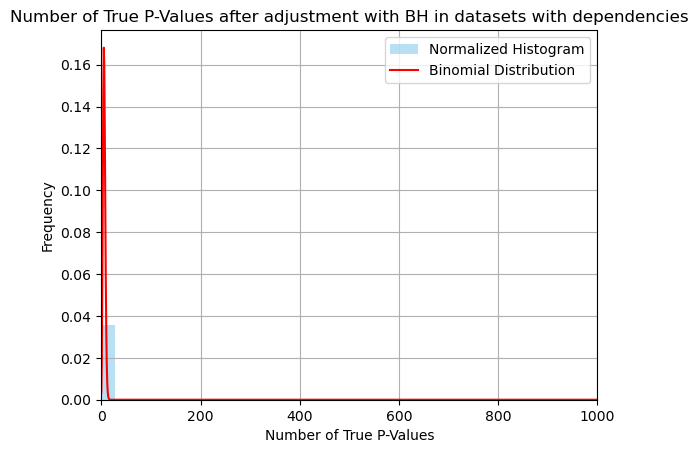

In [24]:
n = adjusted_p_values_pool_binary.shape[0]
p = np.mean(number_of_trues_adjusted_p_values_pool_binary) / n

plt.hist(number_of_trues_adjusted_p_values_pool_binary, color='skyblue',  bins=60, alpha=0.6, label='Normalized Histogram', density=True)

x = np.arange(0, n+1)
pmf = binom.pmf(x, n, p)
plt.plot(x, pmf, color='red', label='Binomial Distribution')
plt.xlabel('Number of True P-Values')
plt.ylabel('Frequency')
plt.title('Number of True P-Values after adjustment with BH in datasets with dependencies')
plt.legend()
plt.grid(True)

plt.xlim(0, 1000)  #zoom in

plt.show()

Although the histogram looks similar to the binomial distribution, if we look into the details, we will see that the histogram is wider and has a longer tail.

We will write down the values different than 0.

In [25]:
number_of_trues_adjusted_p_values_pool_binary_no_zeros = number_of_trues_adjusted_p_values_pool_binary[number_of_trues_adjusted_p_values_pool_binary != 0]

In [26]:
np.sort(number_of_trues_adjusted_p_values_pool_binary_no_zeros)[::-1]

array([1674, 1419, 1381,  513,  440,  210,   13,    6,    2,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1])

We can see that although for 96.4% of datasets no significant sites were found after adjustment, there are still datasets with a lot of significant sites (above 1000). 

Now we plot final comparison. We calculate number of significant sites for each dataset for different alpha levels before and after adjustment.

In [27]:
#alpha = 0.5
p_values_pool_binary_0_5 = p_values_pool_binary < 0.5
number_of_trues_p_values_pool_binary_0_5 = np.sum(p_values_pool_binary_0_5, axis=0)

#alpha = 0.05
p_values_pool_binary_0_05 = p_values_pool < 0.05
number_of_trues_p_values_pool_binary_0_05 = np.sum(p_values_pool_binary_0_05, axis=0)

#alpha = 0.001
p_values_pool_binary_0_001 = p_values_pool < 0.001
number_of_trues_p_values_pool_binary_0_001 = np.sum(p_values_pool_binary_0_001, axis=0)

#alpha = 0.00005
p_values_pool_binary_0_00005 = p_values_pool < 0.00005
number_of_trues_p_values_pool_binary_0_00005 = np.sum(p_values_pool_binary_0_00005, axis=0)

#bh alpha = 0.05
adjusted_p_values_pool_binary_0_05 = adjusted_p_values_pool < 0.05
number_of_trues_adjusted_p_values_pool_binary_0_05 = np.sum(adjusted_p_values_pool_binary_0_05, axis=0)

We calculate smoothed histograms using kernel density estimation for all above variants of alpha and adjustments.

In [28]:
x_range = np.linspace(0, 15000, 1000)
bandwidth_factor = 2.0 

#alpha = 0.5
kde_0_5 = gaussian_kde(number_of_trues_p_values_pool_binary_0_5, bw_method='scott')
kde_0_5.set_bandwidth(bw_method=kde_0_5.factor * bandwidth_factor)
kde_values_0_5 = kde_0_5(x_range)

#alpha = 0.05
kde_0_05 = gaussian_kde(number_of_trues_p_values_pool_binary_0_05, bw_method='scott')
kde_0_05.set_bandwidth(bw_method=kde_0_05.factor * bandwidth_factor)
kde_values_0_05 = kde_0_05(x_range)

#alpha = 0.001
kde_0_001 = gaussian_kde(number_of_trues_p_values_pool_binary_0_001, bw_method='scott')
kde_0_001.set_bandwidth(bw_method=kde_0_001.factor * bandwidth_factor)
kde_values_0_001 = kde_0_001(x_range)

#alpha = 0.00005
kde_0_00005 = gaussian_kde(number_of_trues_p_values_pool_binary_0_00005, bw_method='scott')
kde_0_00005.set_bandwidth(bw_method=kde_0_00005.factor * bandwidth_factor)
kde_values_0_00005 = kde_0_00005(x_range)

#bh alpha = 0.05
kde_bh_0_05 = gaussian_kde(number_of_trues_adjusted_p_values_pool_binary_0_05, bw_method='scott')
kde_bh_0_05.set_bandwidth(bw_method=kde_bh_0_05.factor * bandwidth_factor)
kde_values_bh_0_05 = kde_bh_0_05(x_range)

We plot the smoothed histograms and binomial distributions for different alpha levels and adjusted p values. For binomial we use the probability of type I error.

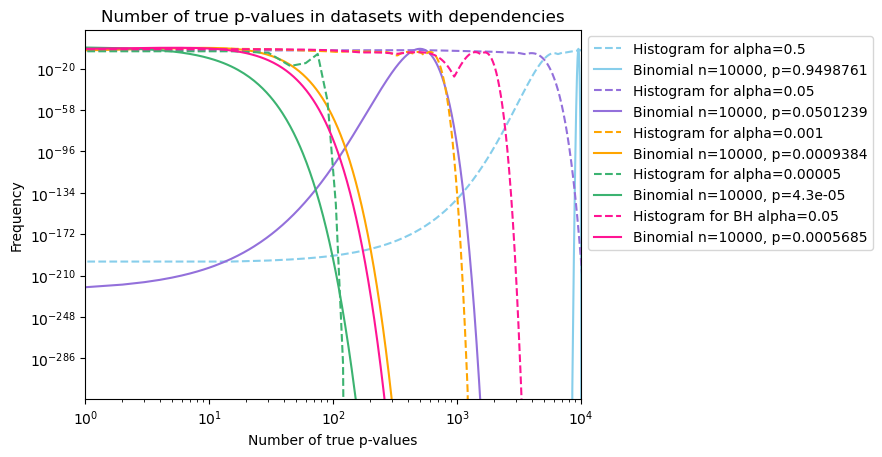

In [39]:
n = 10000
x = np.arange(0, n+5000)

#alpha = 0.5
p_0_5 = np.mean(number_of_trues_p_values_pool_binary_0_5) / n
plt.plot(x_range, kde_values_0_5, linestyle='--', color='skyblue', label='Histogram for alpha=0.5')
pmf_0_5 = binom.pmf(x, n, p_0_5)
plt.plot(x, pmf_0_5, color='skyblue', label=f'Binomial n=10000, p={p_0_5}')

#alpha = 0.05
p_0_05 = np.mean(number_of_trues_p_values_pool_binary_0_05) / n
plt.plot(x_range, kde_values_0_05, linestyle='--', color='mediumpurple', label='Histogram for alpha=0.05')
pmf_0_05 = binom.pmf(x, n, p_0_05)
plt.plot(x, pmf_0_05, color='mediumpurple', label=f'Binomial n=10000, p={p_0_05}')
 
#alpha = 0.001
p_0_001 = np.mean(number_of_trues_p_values_pool_binary_0_001) / n
plt.plot(x_range, kde_values_0_001, linestyle='--', color='orange', label='Histogram for alpha=0.001')
pmf_0_001 = binom.pmf(x, n, p_0_001)
plt.plot(x, pmf_0_001, color='orange', label=f'Binomial n=10000, p={p_0_001}')

#alpha = 0.00005
p_0_00005 = np.mean(number_of_trues_p_values_pool_binary_0_00005) / n
plt.plot(x_range, kde_values_0_00005, linestyle='--', color='mediumseagreen', label='Histogram for alpha=0.00005')
pmf_0_00005 = binom.pmf(x, n, p_0_00005)
plt.plot(x, pmf_0_00005, color='mediumseagreen', label=f'Binomial n=10000, p={p_0_00005}')

#bh alpha = 0.05
p_bh_0_05 = np.mean(number_of_trues_adjusted_p_values_pool_binary_0_05) / n
plt.plot(x_range, kde_values_bh_0_05, linestyle='--', color='deeppink', label='Histogram for BH alpha=0.05')
pmf_bh_0_05 = binom.pmf(x, n, p_bh_0_05)
plt.plot(x, pmf_bh_0_05, color='deeppink', label=f'Binomial n=10000, p={p_bh_0_05}')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1, 10000)
#plt.ylim(1, 10000)
# Add labels and title
plt.xlabel('Number of true p-values')
plt.ylabel('Frequency')
plt.title('Number of true p-values in datasets with dependencies')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

In [30]:
np.sort(number_of_trues_p_values_pool_binary_0_05)

array([ 187,  189,  191,  195,  197,  197,  197,  198,  200,  202,  203,
        203,  203,  203,  204,  204,  205,  205,  206,  206,  207,  207,
        207,  208,  208,  208,  209,  209,  209,  209,  210,  210,  210,
        211,  211,  211,  212,  212,  212,  212,  213,  213,  213,  215,
        215,  215,  215,  216,  216,  216,  217,  217,  217,  217,  218,
        218,  218,  218,  218,  218,  219,  219,  219,  219,  219,  219,
        220,  220,  220,  221,  221,  221,  221,  221,  221,  221,  222,
        222,  222,  222,  223,  223,  223,  224,  224,  224,  224,  224,
        225,  225,  225,  225,  225,  225,  225,  225,  226,  226,  226,
        226,  226,  226,  227,  227,  227,  227,  228,  228,  228,  228,
        228,  229,  229,  229,  229,  229,  230,  230,  230,  230,  230,
        230,  230,  231,  231,  231,  231,  231,  232,  232,  232,  234,
        234,  234,  234,  235,  235,  235,  235,  235,  236,  236,  236,
        236,  236,  236,  236,  236,  236,  236,  2

In [31]:
alpha = 0.5
p_values_pool_binary = p_values_pool < alpha
number_of_trues_p_values_pool_binary = np.sum(p_values_pool_binary, axis=0)

In [32]:
number_of_trues_p_values_pool_binary

array([6042, 6913, 4524, 4094, 3900, 4020, 3851, 4422, 6070, 6037, 4631,
       5794, 5261, 4119, 5439, 4732, 6038, 4093, 4610, 4625, 3615, 4366,
       4093, 5429, 6799, 4545, 4637, 4473, 5912, 5097, 4646, 4396, 5175,
       4450, 4286, 3897, 5027, 3961, 5157, 5014, 4107, 4340, 6294, 5711,
       3759, 4491, 5324, 5337, 4195, 4927, 4155, 4622, 4324, 5124, 7171,
       5600, 4141, 4953, 7944, 3813, 5429, 4851, 5841, 5374, 4284, 4183,
       6413, 5545, 4873, 5186, 4942, 5226, 5628, 4201, 4448, 4772, 6070,
       5941, 4064, 5730, 3983, 6472, 4291, 4331, 4152, 4569, 5341, 3961,
       3672, 5456, 4852, 5996, 4367, 3878, 4061, 4260, 3882, 5075, 5112,
       6461, 5608, 6298, 5108, 4603, 5698, 5205, 4955, 4556, 4323, 4797,
       3930, 4610, 4121, 6356, 4567, 6639, 4766, 5407, 3631, 5033, 5932,
       3743, 5504, 5584, 6293, 5123, 4816, 3871, 5206, 4910, 4619, 4625,
       4013, 5163, 5622, 6732, 4848, 4913, 3803, 3987, 5471, 4909, 5211,
       5474, 4014, 4548, 5355, 6403, 3793, 5586, 56

(array([ 7.,  5.,  7., 15., 15., 16., 18., 21., 18., 15., 13., 20., 20.,
        18., 17., 16., 23., 17., 17., 17., 15., 17., 17., 25., 10., 13.,
        20., 17., 15., 20., 14., 20., 17., 10., 16., 17., 21., 17., 13.,
        17., 17., 20., 17., 11., 15., 15., 21., 17., 12., 12., 13., 10.,
         6., 14.,  9., 11., 13.,  3.,  4.,  2., 12., 10.,  6.,  9.,  7.,
         8.,  0.,  3.,  6.,  6.,  0.,  2.,  7.,  6.,  4.,  2.,  4.,  4.,
         1.,  4.,  2.,  1.,  1.,  1.,  2.,  0.,  2.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([3615.  , 3658.29, 3701.58, 3744.87, 3788.16, 3831.45, 3874.74,
        3918.03, 3961.32, 4004.61, 4047.9 , 4091.19, 4134.48, 4177.77,
        4221.06, 4264.35, 4307.64, 4350.93, 4394.22, 4437.51, 4480.8 ,
        4524.09, 4567.38, 4610.67, 4653.96, 4697.25, 4740.54, 4783.83,
        4827.12, 4870.41, 4913.7 , 4956.99, 5000.28, 5043.57, 5086.86,
        5130.15, 5173.44, 5216.73, 5260.02, 5303.31, 5346.6 , 5389.89,
        

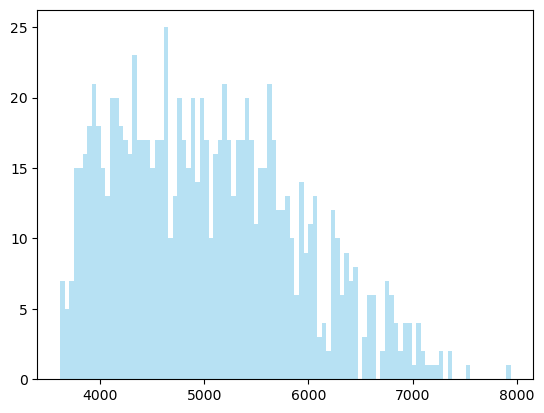

In [33]:
plt.hist(number_of_trues_p_values_pool_binary, color='skyblue', bins=100, alpha=0.6, label='Normalized Histogram')

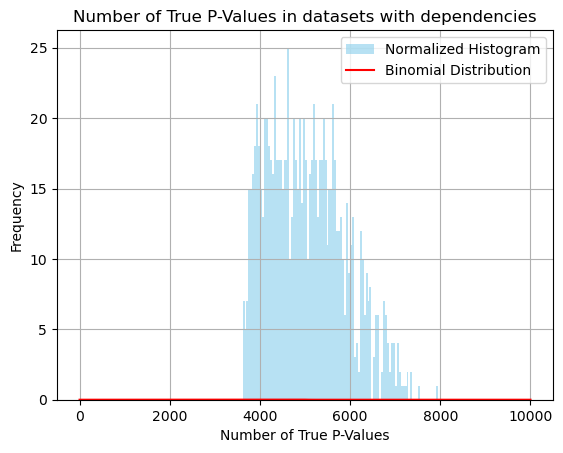

In [34]:
n = p_values_pool_binary.shape[0]
p = 0.5

plt.hist(number_of_trues_p_values_pool_binary, color='skyblue', bins=100, alpha=0.6, label='Normalized Histogram')

x = np.arange(0, n+1)
pmf = binom.pmf(x, n, p)
plt.plot(x, pmf, color='red', label='Binomial Distribution')
plt.xlabel('Number of True P-Values')
plt.ylabel('Frequency')
plt.title('Number of True P-Values in datasets with dependencies')
plt.legend()
plt.grid(True)
# 
# plt.xlim(0, 2000)  #zoom in
# 
# plt.show()

First transform data into log scale and then make a histogram.

In [35]:
number_of_trues_p_values_pool_binary

array([6042, 6913, 4524, 4094, 3900, 4020, 3851, 4422, 6070, 6037, 4631,
       5794, 5261, 4119, 5439, 4732, 6038, 4093, 4610, 4625, 3615, 4366,
       4093, 5429, 6799, 4545, 4637, 4473, 5912, 5097, 4646, 4396, 5175,
       4450, 4286, 3897, 5027, 3961, 5157, 5014, 4107, 4340, 6294, 5711,
       3759, 4491, 5324, 5337, 4195, 4927, 4155, 4622, 4324, 5124, 7171,
       5600, 4141, 4953, 7944, 3813, 5429, 4851, 5841, 5374, 4284, 4183,
       6413, 5545, 4873, 5186, 4942, 5226, 5628, 4201, 4448, 4772, 6070,
       5941, 4064, 5730, 3983, 6472, 4291, 4331, 4152, 4569, 5341, 3961,
       3672, 5456, 4852, 5996, 4367, 3878, 4061, 4260, 3882, 5075, 5112,
       6461, 5608, 6298, 5108, 4603, 5698, 5205, 4955, 4556, 4323, 4797,
       3930, 4610, 4121, 6356, 4567, 6639, 4766, 5407, 3631, 5033, 5932,
       3743, 5504, 5584, 6293, 5123, 4816, 3871, 5206, 4910, 4619, 4625,
       4013, 5163, 5622, 6732, 4848, 4913, 3803, 3987, 5471, 4909, 5211,
       5474, 4014, 4548, 5355, 6403, 3793, 5586, 56